In [77]:
# Data Handling
import pandas as pd
import numpy as np
#  Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [78]:
df = pd.read_csv('yellow_tripdata_2016-03_cleaned.csv')

In [79]:
df

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,total_amount,pickup_date,pickup_time,dropoff_date,dropoff_time
0,2.50,-73.976746,40.765152,-74.004265,40.746128,9.0,12.35,2016-03-01,00:00:00,2016-03-01,00:07:55
1,2.90,-73.983482,40.767925,-74.005943,40.733166,11.0,15.35,2016-03-01,00:00:00,2016-03-01,00:11:06
2,19.98,-73.782021,40.644810,-73.974541,40.675770,54.5,63.80,2016-03-01,00:00:00,2016-03-01,00:31:06
3,10.78,-73.863419,40.769814,-73.969650,40.757767,31.5,41.62,2016-03-01,00:00:00,2016-03-01,00:00:00
4,30.43,-73.971741,40.792183,-74.177170,40.695053,98.0,113.80,2016-03-01,00:00:00,2016-03-01,00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
12134013,12.10,-73.789154,40.646736,-73.875351,40.757648,34.5,40.30,2016-03-20,08:59:21,2016-04-18,10:58:05
12134014,0.40,-73.977356,40.774471,-73.982536,40.772408,4.0,7.50,2016-03-26,03:02:32,2016-06-14,18:47:55
12134015,20.20,0.000000,0.000000,-74.008614,40.710987,52.0,64.34,2016-03-20,08:43:59,2016-06-27,15:05:01
12134016,15.40,-73.790077,40.647377,-73.971756,40.578457,42.5,49.30,2016-03-20,08:49:47,2016-06-28,19:11:27


In [80]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12134018 entries, 0 to 12134017
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   trip_distance      float64
 1   pickup_longitude   float64
 2   pickup_latitude    float64
 3   dropoff_longitude  float64
 4   dropoff_latitude   float64
 5   fare_amount        float64
 6   total_amount       float64
 7   pickup_date        object 
 8   pickup_time        object 
 9   dropoff_date       object 
 10  dropoff_time       object 
dtypes: float64(7), object(4)
memory usage: 1018.3+ MB


Data Cleaning: Outlier Removal Function

In [ ]:
def remove_outliers(df):
    a = df.shape[0]
    print("Total original rows:", a)

    if 'duration_min' not in df.columns:
        print("duration_min not found - computing it...")
        df['pickup_datetime'] = pd.to_datetime(df['pickup_date'] + ' ' + df['pickup_time'])
        df['dropoff_datetime'] = pd.to_datetime(df['dropoff_date'] + ' ' + df['dropoff_time'])
        df['duration_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60.0

    before = df.shape[0]
    df = df[(df['duration_min'] > 1) & (df['duration_min'] < 720)]
    after = df.shape[0]
    print("Duration outliers removed:", before - after)

    before = df.shape[0]
    df = df[(df['trip_distance'] > 1) & (df['trip_distance'] < 23)]
    after = df.shape[0]
    print("Distance outliers removed:", before - after)

    if 'Speed' not in df.columns:
        df['Speed'] = df['trip_distance'] / (df['duration_min'] / 60.0)

    before = df.shape[0]
    df = df[(df['Speed'] >= 0.5) & (df['Speed'] <= 80)]
    after = df.shape[0]
    print("Speed outliers removed:", before - after)

    before = df.shape[0]
    df = df[(df['total_amount'] > 1) & (df['total_amount'] < 200)]
    after = df.shape[0]
    print("Fare outliers removed:", before - after)

    print("\nTotal outliers removed overall:", a - df.shape[0])
    return df


df = remove_outliers(df)
print("After cleaning shape:", df.shape)


Total original rows: 12134018
duration_min not found - computing it...
Duration outliers removed: 58143
Distance outliers removed: 3057233
Speed outliers removed: 1232
Fare outliers removed: 277

Total outliers removed overall: 3116885
After cleaning shape: (9017133, 15)


In [ ]:
# Sample a smaller subset for faster computation 
df_sample = df.sample(9000000, random_state=42)
# Select features for clustering
X = df_sample[['trip_distance','fare_amount','duration_min','Speed']]
# Data Preprocessing: Scaling features for K-Means
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



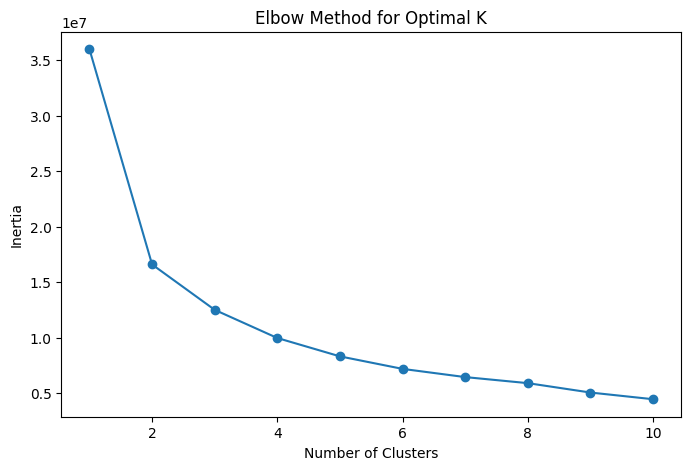

In [ ]:
from sklearn.cluster import KMeans
# Determine the optimal number of clusters (K) using the Elbow Method
inertia = []
K_range = range(1,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
# Plot the Elbow Method results
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Initialize PCA to reduce data to 2 principal components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)
# Add PCA components back to the sample DataFrame for plotting
df_sample['PCA1'] = pca_data[:, 0]
df_sample['PCA2'] = pca_data[:, 1]

print("PCA Components added successfully to df_sample.")
print(f"Shape of df_sample: {df_sample.shape}")
# K-Means Clustering with the chosen optimal K (optimal_k = 8 based on the elbow plot)
optimal_k = 8 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# Fit K-Means on the 2D PCA data and predict cluster labels
cluster_labels = kmeans.fit_predict(pca_data)
# Add cluster labels to the DataFrame
df_sample['cluster'] = cluster_labels
print("K-Means clustering labels added successfully.")


PCA Components added successfully to df_sample.
Shape of df_sample: (9000000, 18)
K-Means clustering labels added successfully.


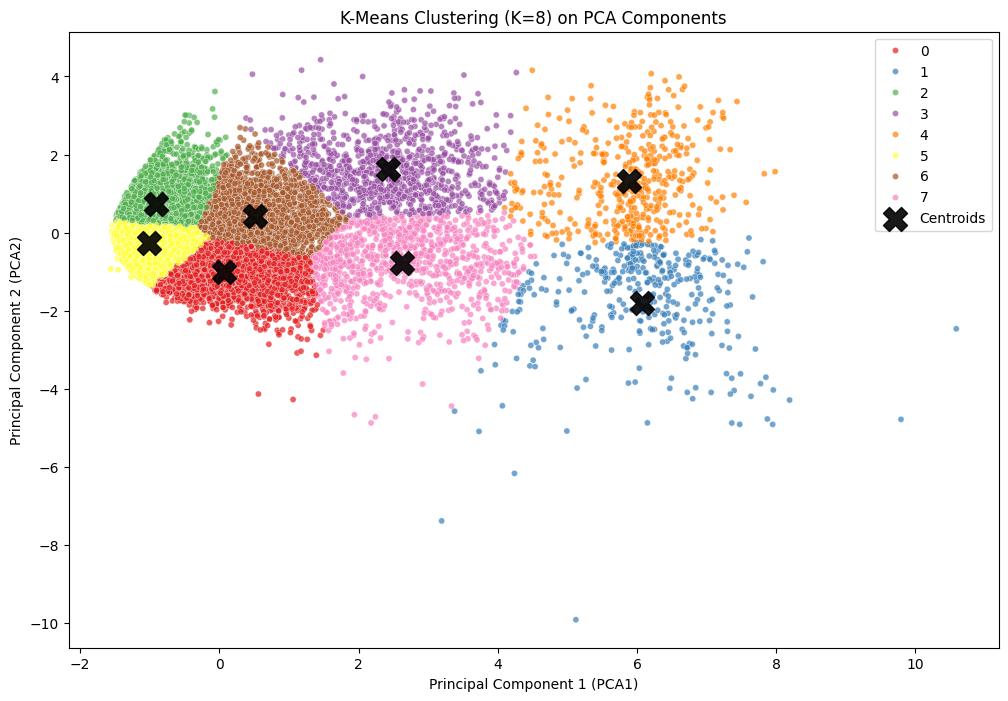

In [ ]:
# Plotting the K-Means clusters on the 2D PCA plane
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_sample.sample(20000, random_state=1),
    x='PCA1', y='PCA2',
    hue='cluster', palette='Set1', alpha=0.7,
    s=20
)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.9, marker='X', label='Centroids')


plt.title(f"K-Means Clustering (K={optimal_k}) on PCA Components")
plt.xlabel("Principal Component 1 (PCA1)")
plt.ylabel("Principal Component 2 (PCA2)")
plt.legend()
plt.show()

In [ ]:
# Analyze and Summarize Cluster Characteristics
print("\n" + "="*50)
print("Cluster Summary (Mean values of original features):")
cluster_summary = df_sample.groupby('cluster')[
    ['trip_distance','fare_amount','duration_min','Speed']
].mean()

cluster_summary['count'] = df_sample.groupby('cluster').size()
cluster_summary['count_pct'] = (cluster_summary['count'] / len(df_sample)) * 100

print(cluster_summary.sort_values(by='count', ascending=False))


Cluster Summary (Mean values of original features):
         trip_distance  fare_amount  duration_min      Speed    count  \
cluster                                                                 
5             1.719959     9.659337     12.108715   8.663320  3353418   
2             1.857655     8.169429      7.703226  14.696789  2003144   
0             3.208124    16.789182     23.893777   8.176530  1304813   
6             4.669755    16.892259     17.224381  16.615019  1037949   
7             8.861006    31.574267     35.260488  15.539433   481095   
3             8.828007    26.661933     19.692829  27.589140   433843   
4            17.424980    50.994332     33.571983  32.055420   211694   
1            16.782887    51.827940     58.875622  18.057879   174044   

         count_pct  
cluster             
5        37.260200  
2        22.257156  
0        14.497922  
6        11.532767  
7         5.345500  
3         4.820478  
4         2.352156  
1         1.933822  


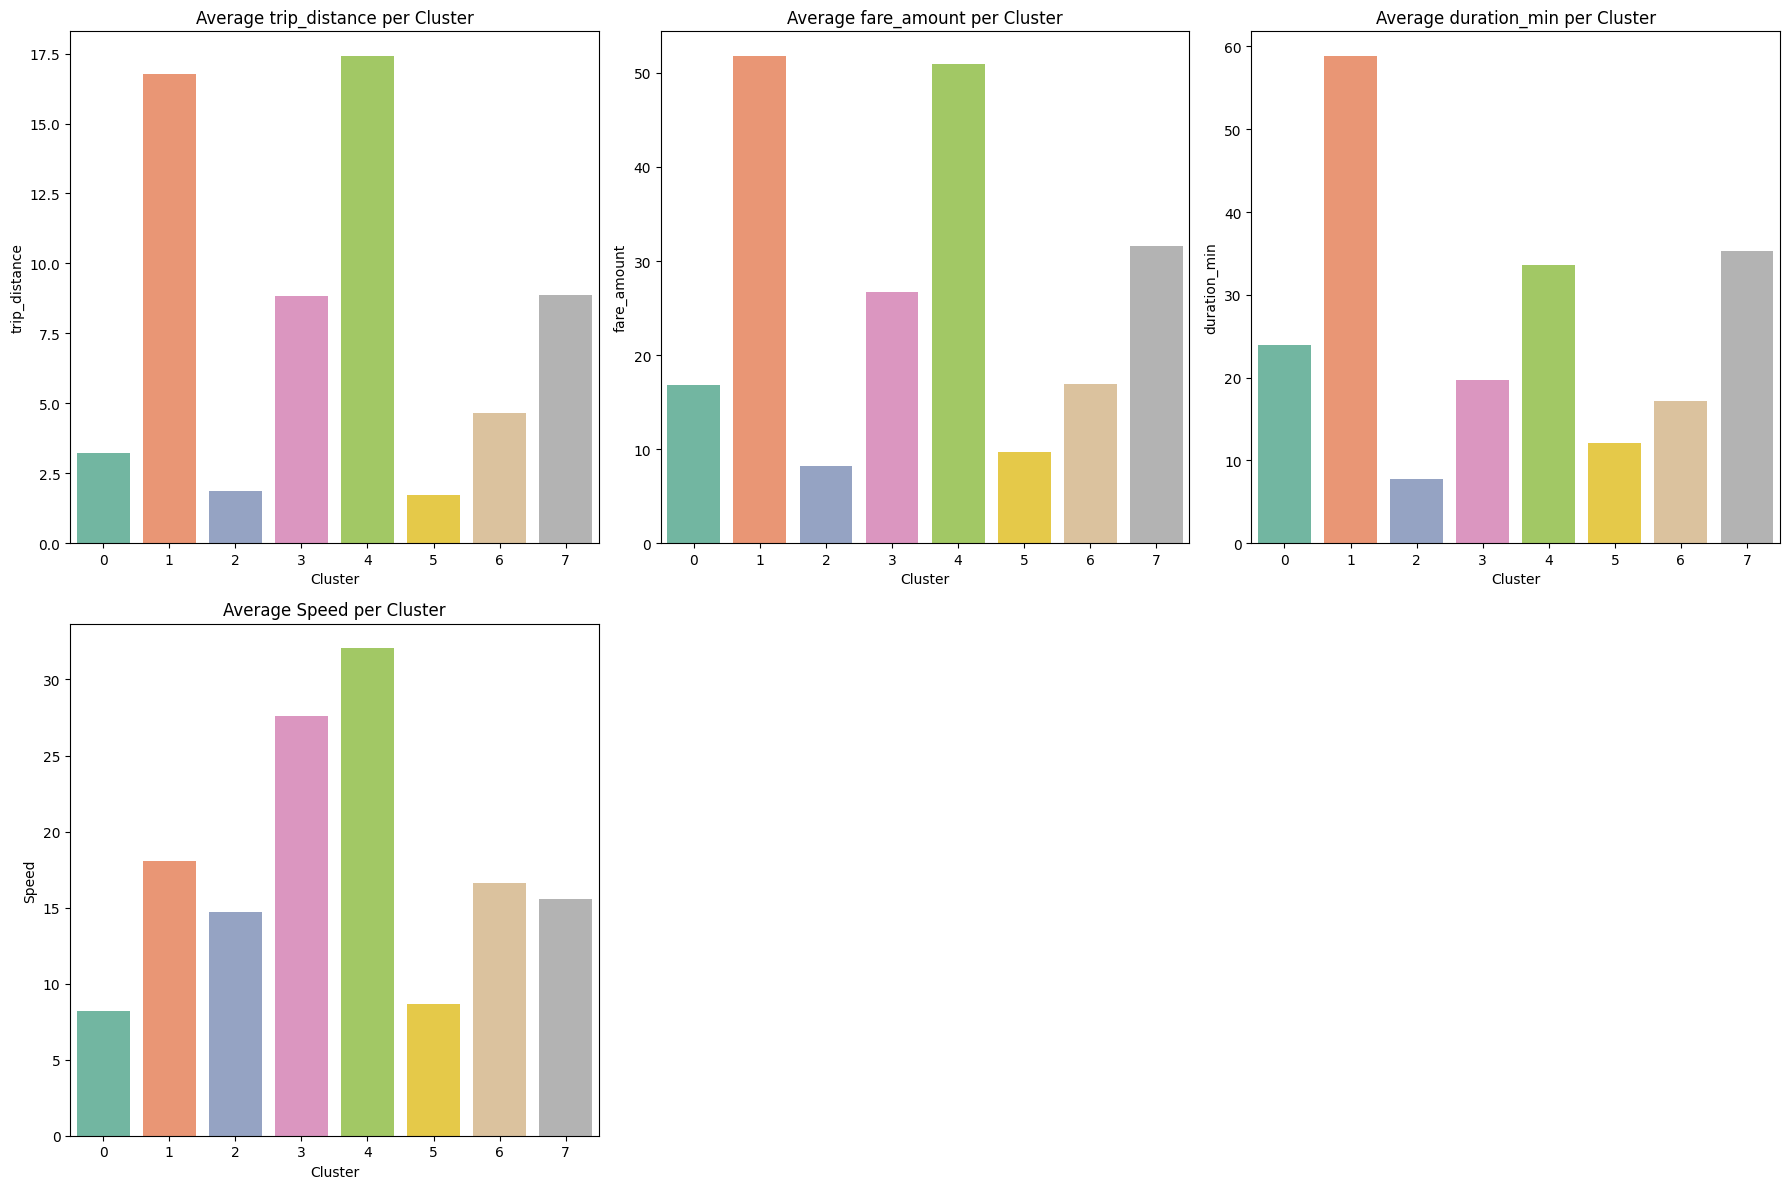

In [ ]:

# Visualization of Cluster Characteristics
features = ['trip_distance', 'fare_amount', 'duration_min', 'Speed']

plt.figure(figsize=(18,12))
# Generate a bar plot for the average of each feature per cluster
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=cluster_summary.index, y=cluster_summary[feature], palette='Set2')
    plt.title(f'Average {feature} per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()
